In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [40]:
pd.options.display.float_format='{:.2f}'.format
pd.set_option('display.max_columns',None) # display columns from text pd.set_option('display.max_rows',None) # display rows from text

In [ ]:


df2018 = pd.read_csv('/Users/kkola/Econ433/weekly_patterns_2018_sample.csv.zip', compression='zip')
df2019 = pd.read_csv('/Users/kkola/Econ433/weekly_patterns_2019_sample.csv.zip', compression='zip')
df2020 = pd.read_csv('/Users/kkola/Econ433/weekly_patterns_2020_sample.csv.zip', compression='zip')
df2021 = pd.read_csv('/Users/kkola/Econ433/weekly_patterns_2021_sample.csv.zip', compression='zip')
df2022 = pd.read_csv('/Users/kkola/Econ433/weekly_patterns_2022_sample.csv.zip', compression='zip')

# combine to single data frame
conc1 = pd.concat([df2018, df2019, df2020, df2021, df2022], ignore_index=True)

# clena date start and end range columns
raw_datetime_start = conc1['date_range_start']
raw_datetime_end = conc1['date_range_end']

# convert to datetime
conc1['date_range_start'] = raw_datetime_start.str.slice(0, 10)
conc1['date_range_start'] = pd.to_datetime(conc1['date_range_start'])
conc1['date_range_end'] = raw_datetime_end.str.slice(0, 10)
conc1['date_range_end'] = pd.to_datetime(conc1['date_range_end'])

# Split 'visits_by_day' into daily visits for each day of the week
conc1['visits_by_day'] = conc1['visits_by_day'].str.strip('[]')
conc1[['dailyvisits1', 'dailyvisits2', 'dailyvisits3', 'dailyvisits4', 'dailyvisits5', 'dailyvisits6', 'dailyvisits7']] = conc1['visits_by_day'].str.split(",", expand=True)

# Convert the daily visits columns to integers
conc1 = conc1.astype({"dailyvisits1": "int", "dailyvisits2": "int", "dailyvisits3": "int",
                      "dailyvisits4": "int", "dailyvisits5": "int", "dailyvisits6": "int", "dailyvisits7": "int"})

# Reshape the data from wide to long format
conc1['id'] = conc1.index
df_long_sample = pd.wide_to_long(conc1, 'dailyvisits', i='id', j='index', sep='').reset_index()

#  Created new_date by adding the day index to ate_range_start
df_long_sample['new_date'] = df_long_sample['date_range_start'] + (pd.to_timedelta(df_long_sample['index'], unit='d') - pd.Timedelta("1D"))

#  Create the day_of_week variable (1 = Monday, 7 = Sunday)
df_long_sample['day_of_week'] = df_long_sample['new_date'].dt.weekday + 1

# Generate the 'weekend' variable (1 if Saturday or Sunday, 0 otherwise)
df_long_sample['weekend'] = df_long_sample['day_of_week'].apply(lambda x: 1 if x in [6, 7] else 0)

# created the 'manyvisits' variable (1 if dailyvisits > 15, 0 otherwise)
df_long_sample['manyvisits'] = (df_long_sample['dailyvisits'] > 15).astype(int)

#  Created the 'core_biz_area' variable based on the top 25% of locations by region size
location_counts = df_long_sample.groupby('region').size()
X = location_counts.quantile(0.75)  # Top 25%
core_biz_area_indicator = (location_counts >= X).astype(int)
df_long_sample['core_biz_area'] = df_long_sample['region'].map(core_biz_area_indicator)

# Save the long data to a CSV file
df_long_sample.to_csv('long_sample.csv', index=False)

#  Generate core_biz_area summary
core_biz_area_summary = df_long_sample.groupby('core_biz_area').agg(
    num_observations=('core_biz_area', 'size'), 
    mean_dailyvisits=('dailyvisits', 'mean')    
).reset_index()

print(core_biz_area_summary)

#  Sanity check - unique values of 'day_of_week' and weekend/weekday counts
print("Unique values of day_of_week:", df_long_sample['day_of_week'].unique())
weekend_count = df_long_sample['weekend'].value_counts()
print("Weekend vs Weekdays count:\n", weekend_count)


1.C 
1-7 for day_of_week values, 
32311175 observations for weekday and 12924470 observations for the weekend

In [3]:
# Total number of observations
total_observations = df_long_sample.shape[0]

# Descriptive statistics for 'dailyvisits'
min_dailyvisits = df_long_sample['dailyvisits'].min()
max_dailyvisits = df_long_sample['dailyvisits'].max()
avg_dailyvisits = df_long_sample['dailyvisits'].mean()
median_dailyvisits = df_long_sample['dailyvisits'].median()

#  Number of observations with dailyvisits equal to zero
dailyvisits_zero = df_long_sample[df_long_sample['dailyvisits'] == 0].shape[0]

# Number of observations with dailyvisits >= 100
dailyvisits_above_100 = df_long_sample[df_long_sample['dailyvisits'] >= 100].shape[0]

# Number of observations with dailyvisits >= 1000
dailyvisits_above_1000 = df_long_sample[df_long_sample['dailyvisits'] >= 1000].shape[0]

# Print the results
print(f"Total number of observations: {total_observations}")
print(f"Minimum dailyvisits: {min_dailyvisits}")
print(f"Maximum dailyvisits: {max_dailyvisits}")
print(f"Average dailyvisits: {avg_dailyvisits:.2f}")
print(f"Median dailyvisits: {median_dailyvisits}")
print(f"Number of observations with dailyvisits equal to 0: {dailyvisits_zero}")
print(f"Number of observations with dailyvisits >= 100: {dailyvisits_above_100}")
print(f"Number of observations with dailyvisits >= 1000: {dailyvisits_above_1000}")


Total number of observations: 45235645
Minimum dailyvisits: 0
Maximum dailyvisits: 6276
Average dailyvisits: 17.14
Median dailyvisits: 11.0
Number of observations with dailyvisits equal to 0: 2419564
Number of observations with dailyvisits >= 100: 501879
Number of observations with dailyvisits >= 1000: 943


2.a

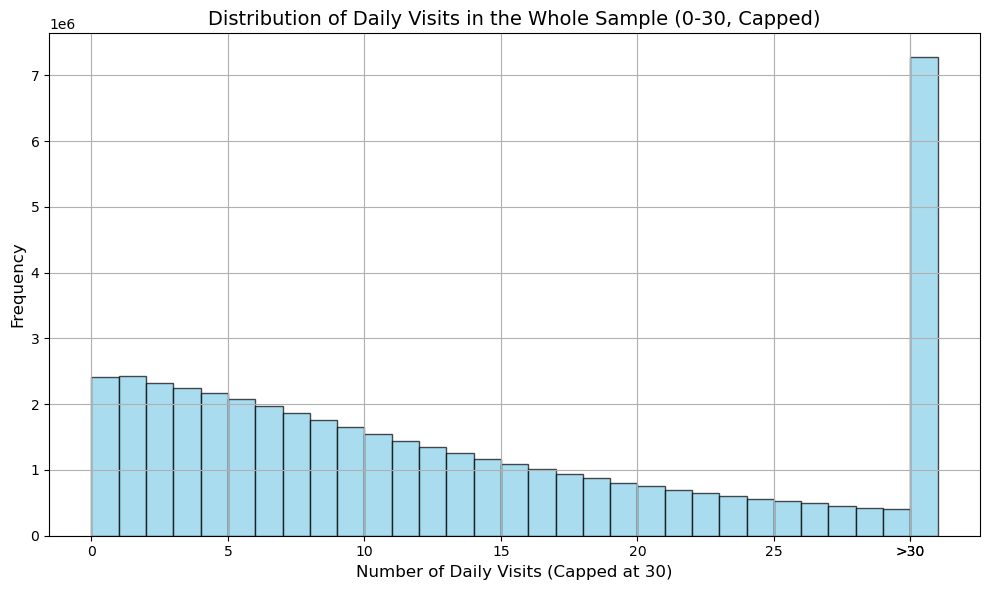

In [4]:
import matplotlib.pyplot as plt

# Capped daily visits at 30
dailyvisits_capped = df_long_sample['dailyvisits'].apply(lambda x: 30 if x > 30 else x)

#  Create the histogram with capped group
plt.figure(figsize=(10, 6))
plt.hist(dailyvisits_capped, bins=31, range=(0, 31), color='skyblue', edgecolor='black', alpha=0.7)

# label, axis , grapgh
plt.xlabel('Number of Daily Visits (Capped at 30)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Daily Visits in the Whole Sample (0-30, Capped)', fontsize=14)

# readability
plt.xticks(list(range(0, 31, 5)) + [30], labels=list(range(0, 31, 5)) + ['>30'])  # Add '>30' label at 30

# Displaying  histogram
plt.grid(True)
plt.tight_layout()
plt.show()


2.b used 0-30 for the range since  the mean was around, also all observations greater than 30 would be counted as 30.

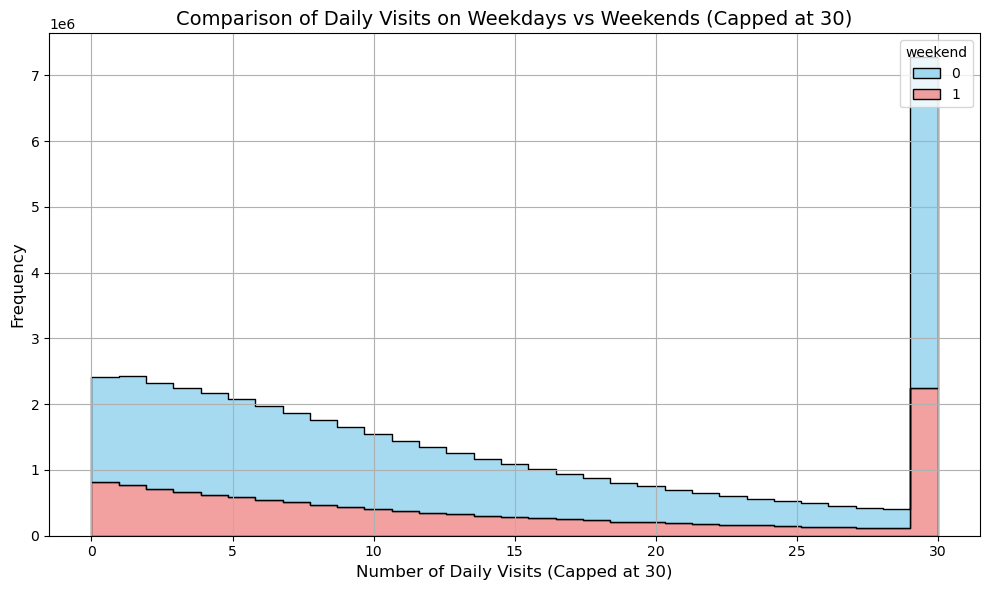

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

#  Preparing the data by capping dailyvisits at 30
df_long_sample['dailyvisits_capped'] = df_long_sample['dailyvisits'].apply(lambda x: 30 if x > 30 else x)

df_long_sample['weekend'] = df_long_sample['day_of_week'].apply(lambda x: 1 if x in [6, 7] else 0)

#  Plot the grouped histogram using Seaborn
plt.figure(figsize=(10, 6))

# Use sns.histplot to draw grouped histogram with hue
sns.histplot(data=df_long_sample, x='dailyvisits_capped', hue='weekend', bins=31, element='step', palette=['skyblue', 'lightcoral'], 
             multiple='stack', kde=False)

plt.xlabel('Number of Daily Visits (Capped at 30)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Comparison of Daily Visits on Weekdays vs Weekends (Capped at 30)', fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()


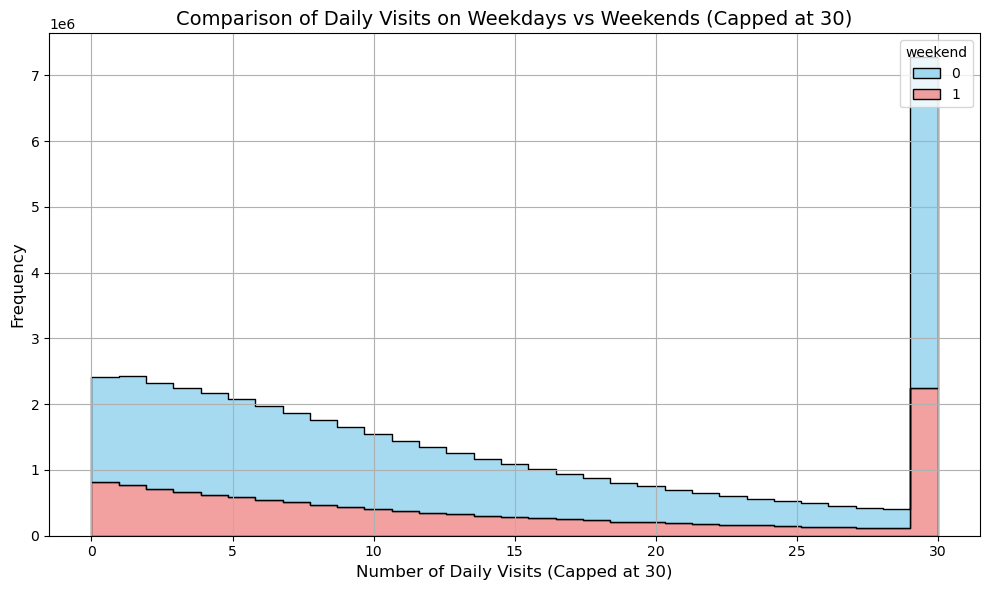

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

df_long_sample['dailyvisits_capped'] = df_long_sample['dailyvisits'].apply(lambda x: 30 if x > 30 else x)
df_long_sample['weekend'] = df_long_sample['day_of_week'].apply(lambda x: 1 if x in [6, 7] else 0)

plt.figure(figsize=(10, 6))

sns.histplot(data=df_long_sample, x='dailyvisits_capped', hue='weekend', bins=31, element='step', palette=['skyblue', 'lightcoral'], 
             multiple='stack', kde=False)

plt.xlabel('Number of Daily Visits (Capped at 30)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Comparison of Daily Visits on Weekdays vs Weekends (Capped at 30)', fontsize=14)
plt.tight_layout()
plt.grid(True)
plt.show()


2.c We see that the number of dailiy visits is higher for weekdays on all frequencies, and this can be exaplained by Chipotle being a chain that people come to more often, for example office workers migh eat here regulary. If this chain was a more "high end" resturant we could see this flipped.

In [7]:

# Group the data by 'dayofweek' and calculate the sum of 'dailyvisits'
sum_dailyvisits_by_day = df_long_sample.groupby('day_of_week')['dailyvisits'].sum()

#  Map dayofweek numbers to the actual weekday names
day_mapping = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
sum_dailyvisits_by_day.index = sum_dailyvisits_by_day.index.map(day_mapping)

# Convert the results into a table (DataFrame) for display
dailyvisits_summary_table = pd.DataFrame({'Day of Week': sum_dailyvisits_by_day.index, 'Total Daily Visits': sum_dailyvisits_by_day.values})

# Display the table
print(dailyvisits_summary_table)


  Day of Week  Total Daily Visits
0      Monday           100717012
1     Tuesday           102281917
2   Wednesday           106246156
3    Thursday           110192514
4      Friday           130315475
5    Saturday           126155056
6      Sunday            99568584


3.a

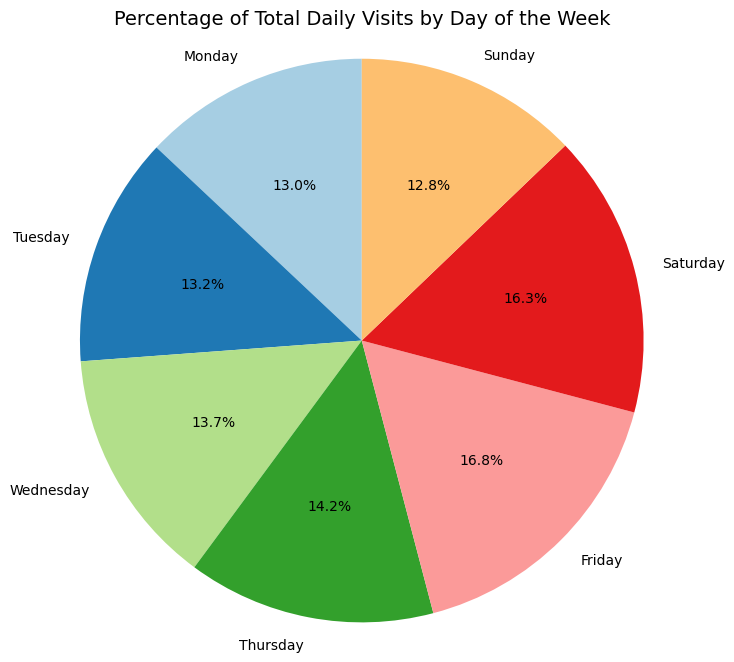

In [8]:
import matplotlib.pyplot as plt

# Calculate the sum of daily visits by day_of_week
sum_dailyvisits_by_day = df_long_sample.groupby('day_of_week')['dailyvisits'].sum()

# Map day_of_week numbers to actual weekday names
day_mapping = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
sum_dailyvisits_by_day.index = sum_dailyvisits_by_day.index.map(day_mapping)

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sum_dailyvisits_by_day, labels=sum_dailyvisits_by_day.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors, startangle=90)

# Adding a title and make sure the pie chart is a circle
plt.title('Percentage of Total Daily Visits by Day of the Week', fontsize=14)
plt.axis('equal')

plt.show()


3.b

In [9]:
#Using region for gepgrapghic variable for size managability
avg_dailyvisits_by_region = df_long_sample.groupby('region')['dailyvisits'].mean().reset_index()
avg_dailyvisits_by_region.columns = ['Region', 'Average Daily Visits']

print(avg_dailyvisits_by_region)


   Region  Average Daily Visits
0      AK             12.276134
1      AL             26.947299
2      AR             27.676162
3      AZ             14.613069
4      CA             12.284893
5      CO             11.985254
6      CT             11.132285
7      DC             12.578817
8      DE             14.384702
9      FL             18.550111
10     GA             22.096166
11     HI             14.617945
12     IA             17.148018
13     ID             12.493900
14     IL             14.175124
15     IN             18.101833
16     KS             20.101361
17     KY             19.963074
18     LA             23.128733
19     MA             11.167887
20     MD             13.444723
21     ME             10.128995
22     MI             13.940203
23     MN             12.363883
24     MO             23.383021
25     MS             29.750117
26     MT             10.120113
27     NC             18.817555
28     ND             12.020168
29     NE             16.692124
30     N

4.a

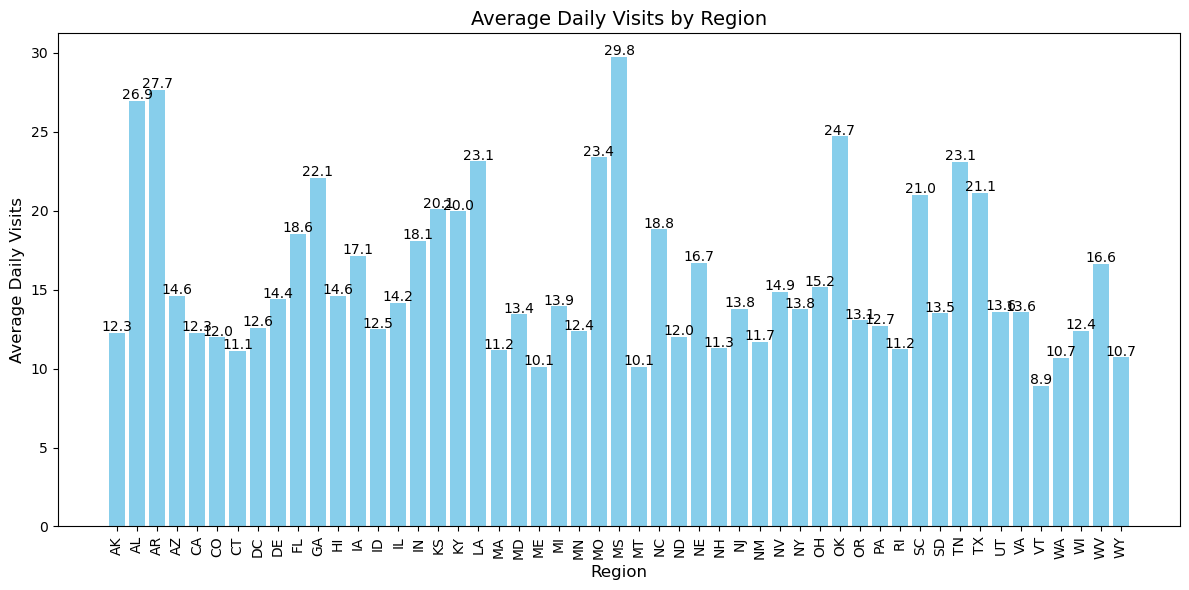

In [10]:

# average dailiy visits by regioun
avg_dailyvisits_by_region = df_long_sample.groupby('region')['dailyvisits'].mean().reset_index()

# Rename columns for readability
avg_dailyvisits_by_region.columns = ['Region', 'Average Daily Visits']

# Creating the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(avg_dailyvisits_by_region['Region'], avg_dailyvisits_by_region['Average Daily Visits'], color='skyblue')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 1), ha='center', fontsize=10)


plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Daily Visits', fontsize=12)
plt.title('Average Daily Visits by Region', fontsize=14)


plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()


4.b

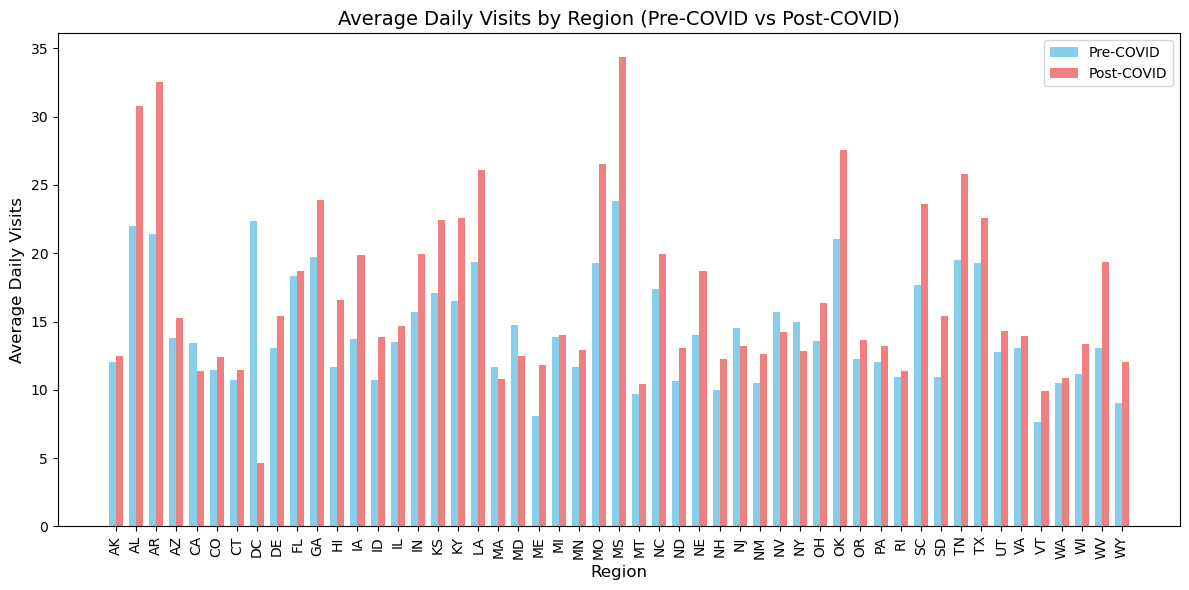

In [11]:

# Filter the data for dates before and after March 13, 2020
pre_covid_data = df_long_sample[df_long_sample['new_date'] <= '2020-03-13']
post_covid_data = df_long_sample[df_long_sample['new_date'] > '2020-03-13']

# Calculate the average daily visits by region for both periods
avg_pre_covid = pre_covid_data.groupby('region')['dailyvisits'].mean().reset_index()
avg_post_covid = post_covid_data.groupby('region')['dailyvisits'].mean().reset_index()

# Renaming columns 
avg_pre_covid.columns = ['Region', 'Average Daily Visits (Pre-COVID)']
avg_post_covid.columns = ['Region', 'Average Daily Visits (Post-COVID)']

# Merge both datasets so we can plot them side by side
avg_visits_combined = pd.merge(avg_pre_covid, avg_post_covid, on='Region', how='inner')

# Ploting the grouped bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(avg_visits_combined))

# Creating bars for pre-COVID and post-COVID periods
bar1 = plt.bar([i - bar_width/2 for i in index], avg_visits_combined['Average Daily Visits (Pre-COVID)'], 
               bar_width, label='Pre-COVID', color='skyblue')
bar2 = plt.bar([i + bar_width/2 for i in index], avg_visits_combined['Average Daily Visits (Post-COVID)'], 
               bar_width, label='Post-COVID', color='lightcoral')

plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Daily Visits', fontsize=12)
plt.title('Average Daily Visits by Region (Pre-COVID vs Post-COVID)', fontsize=14)
plt.xticks(index, avg_visits_combined['Region'], rotation=90)

plt.legend()
plt.tight_layout()
plt.show()


4.c 

1.We see the post-COVID numbers to be higher than the pre-covid, this is wierd but can be explained by the fact people might prefer take out, deliviery and what not during this time from chipotle. We also can have confidence in this because the stock price of Chipotle did increase Post-Covid. 

2.Another  difference is that for desnly populated areas, like DC and NY, the Pre-Covid numbers where actually stronger than the Post-Covid numbers.

In [12]:

# creating year month column
df_long_sample['year_month'] = df_long_sample['new_date'].dt.to_period('M')

# Calculate the average daily visits grouped by year-month
avg_dailyvisits_by_month = df_long_sample.groupby('year_month')['dailyvisits'].mean().reset_index()

# Rename the columns for clarity
avg_dailyvisits_by_month.columns = ['Year-Month', 'Average Daily Visits']

print(avg_dailyvisits_by_month)
# using this to confirm 5.a result
unique_year_months = df_long_sample['year_month'].nunique()


   Year-Month  Average Daily Visits
0     2018-01              8.477587
1     2018-02             10.201988
2     2018-03             11.964386
3     2018-04             13.731424
4     2018-05             13.528268
..        ...                   ...
56    2022-09             18.022983
57    2022-10             18.886528
58    2022-11             17.611478
59    2022-12             19.074541
60    2023-01              4.715583

[61 rows x 2 columns]


5.a

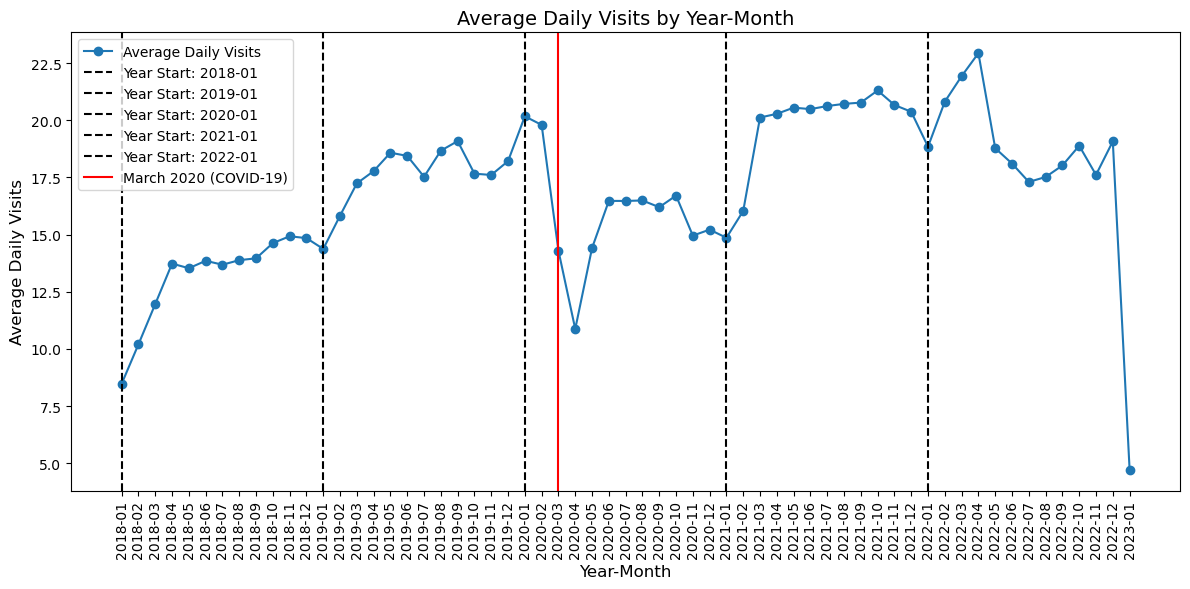

In [13]:

# Extract the year-month and calculate the average daily visits
df_long_sample['year_month'] = df_long_sample['new_date'].dt.to_period('M')
avg_dailyvisits_by_month = df_long_sample.groupby('year_month')['dailyvisits'].mean().reset_index()

# Converting the 'year_month' column to string for plotting
avg_dailyvisits_by_month['year_month_str'] = avg_dailyvisits_by_month['year_month'].astype(str)

# Plot the line chart for average daily visits
plt.figure(figsize=(12, 6))
plt.plot(avg_dailyvisits_by_month['year_month_str'], avg_dailyvisits_by_month['dailyvisits'], marker='o', label='Average Daily Visits')

# Added vertical lines for the beginning of each year
years = ['2018-01', '2019-01', '2020-01', '2021-01', '2022-01']
for year in years:
    plt.axvline(x=year, color='black', linestyle='--', label=f'Year Start: {year}')

# Added a vertical line for March 2020
plt.axvline(x='2020-03', color='red', linestyle='-', label='March 2020 (COVID-19)')

# plot options
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Average Daily Visits', fontsize=12)
plt.title('Average Daily Visits by Year-Month', fontsize=14)
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


5.b

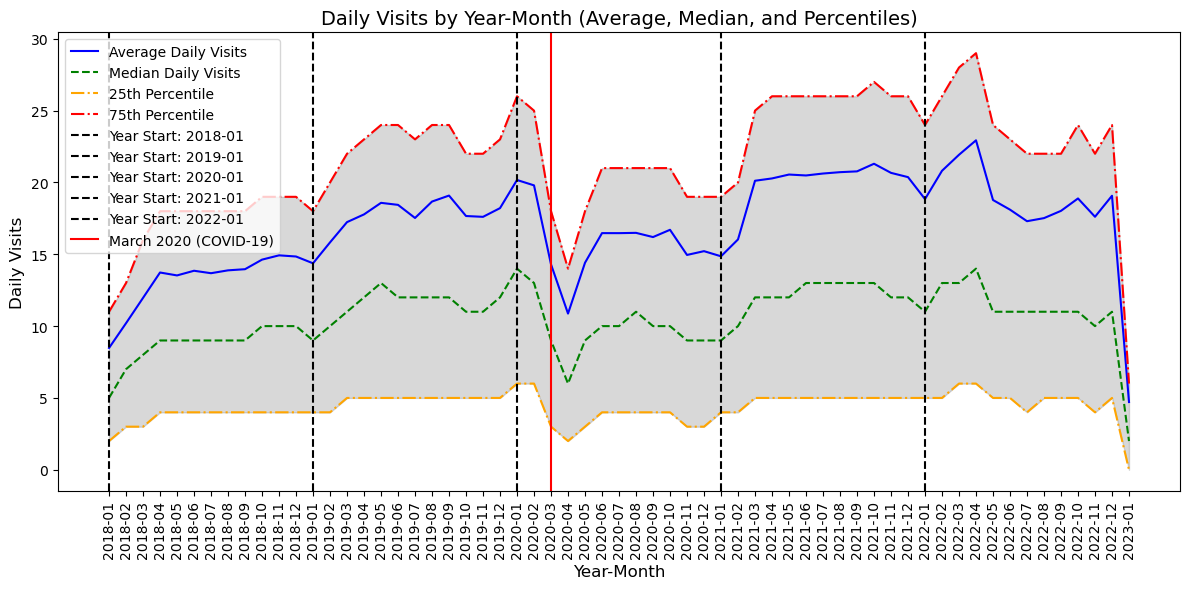

In [14]:

# Extract the year-month from new-date
df_long_sample['year_month'] = df_long_sample['new_date'].dt.to_period('M')

# Group by year-month 
metrics_by_month = df_long_sample.groupby('year_month')['dailyvisits'].agg(
    avg_visits='mean',
    median_visits='median',
    perc_25=lambda x: x.quantile(0.25),
    perc_75=lambda x: x.quantile(0.75)
).reset_index()

# Convert 'year_month' to string to make it plottable
metrics_by_month['year_month_str'] = metrics_by_month['year_month'].astype(str)

# Plot the lines for each metric
plt.figure(figsize=(12, 6))

# average
plt.plot(metrics_by_month['year_month_str'], metrics_by_month['avg_visits'], label='Average Daily Visits', color='blue', linestyle='-')

# median
plt.plot(metrics_by_month['year_month_str'], metrics_by_month['median_visits'], label='Median Daily Visits', color='green', linestyle='--')

# Plot the 25th and 75th percentiles
plt.plot(metrics_by_month['year_month_str'], metrics_by_month['perc_25'], label='25th Percentile', color='orange', linestyle='-.')
plt.plot(metrics_by_month['year_month_str'], metrics_by_month['perc_75'], label='75th Percentile', color='red', linestyle='-.')

# Shade the area between the 25th and 75th percentiles
plt.fill_between(metrics_by_month['year_month_str'], metrics_by_month['perc_25'], metrics_by_month['perc_75'], color='grey', alpha=0.3)

# Add vertical lines for the beginning of each year
years = ['2018-01', '2019-01', '2020-01', '2021-01', '2022-01']
for year in years:
    plt.axvline(x=year, color='black', linestyle='--', label=f'Year Start: {year}')

# Add a vertical line for March 2020
plt.axvline(x='2020-03', color='red', linestyle='-', label='March 2020 (COVID-19)')

# Customize the plot with labels, title, and legend
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Daily Visits', fontsize=12)
plt.title('Daily Visits by Year-Month (Average, Median, and Percentiles)', fontsize=14)
plt.xticks(rotation=90)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


5.c

1. We see right after covid, their is a drop of Daily visits by Year-month amongs all groups.
2. We also see that the 75th percentile and the avwerage group to increase to levels higher post Covid.

<Figure size 1200x600 with 0 Axes>

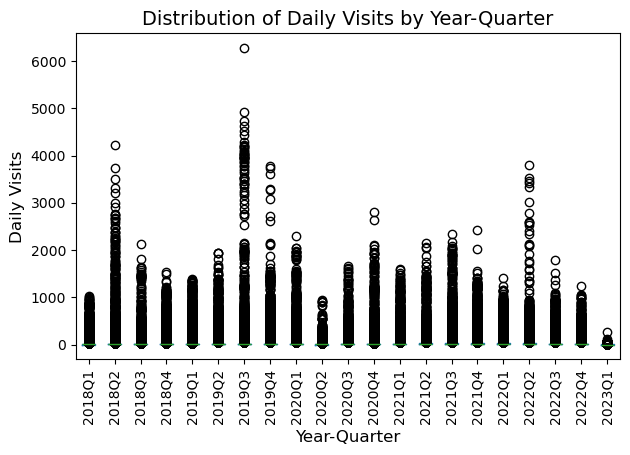

In [15]:

# Extract the year and quarter from 'new_date'
df_long_sample['year_quarter'] = df_long_sample['new_date'].dt.to_period('Q')

# box plot by quarters
plt.figure(figsize=(12, 6))

# Create the boxplot
df_long_sample.boxplot(column='dailyvisits', by='year_quarter', grid=False)

plt.xlabel('Year-Quarter', fontsize=12)
plt.ylabel('Daily Visits', fontsize=12)
plt.title('Distribution of Daily Visits by Year-Quarter', fontsize=14)
plt.suptitle('') #removing the subtitle that automatically comes
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


6. We see that the activity does drop right after Covid just like indicated in the line chart. We also see the IQR being lower after covid than pre-covid, which may indicate customers being more conscious about eating here or being more picky about their eating habits.

In [16]:
import sys
print(sys.executable)



/opt/anaconda3/bin/python


#NOTE TO TA
I was having issues with pip install, my mac uses homebrew for isntalling, so the paths are different from pp, so I had to use this to figure it out and create a new kernal env and redirect installations their for python

7.

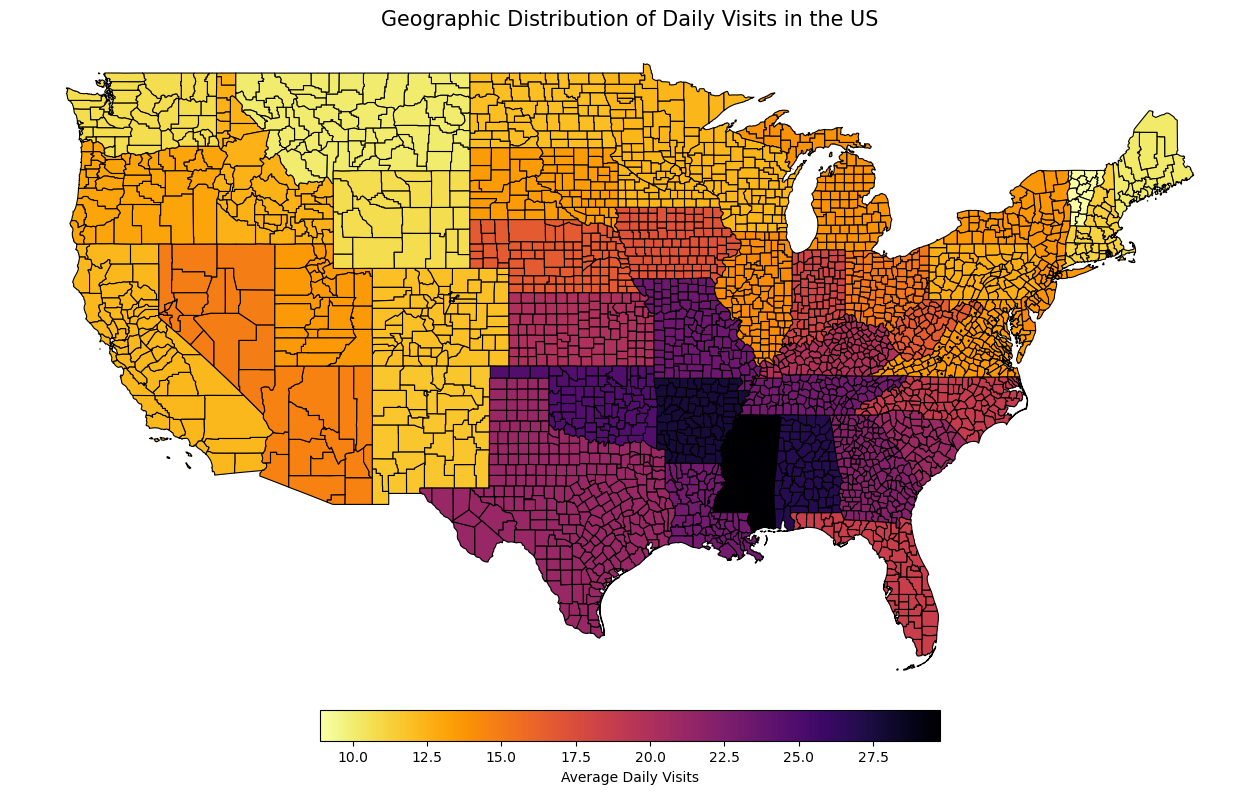

In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc

# Loading the US counties GeoJSON file
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')
geoData['id'] = geoData['id'].astype(str).astype(int)

# Remove Alaska, Hawaii, and Puerto Rico, the grapgh becomes a mess with it, additionaly its not a focus group
stateToRemove = ['02', '15', '72']
geoData = geoData[~geoData['STATE'].isin(stateToRemove)]

# Assuming df_state contains the state-level dailyvisits data (from previous questions)
# Create a state code mapping to match GeoJSON data
state_id = {
    'AL': '01', 'AK': '02', 'AZ': '04', 'AR': '05', 'CA': '06',
    'CO': '08', 'CT': '09', 'DE': '10', 'FL': '12', 'GA': '13',
    'HI': '15', 'ID': '16', 'IL': '17', 'IN': '18', 'IA': '19',
    'KS': '20', 'KY': '21', 'LA': '22', 'ME': '23', 'MD': '24',
    'MA': '25', 'MI': '26', 'MN': '27', 'MS': '28', 'MO': '29',
    'MT': '30', 'NE': '31', 'NV': '32', 'NH': '33', 'NJ': '34',
    'NM': '35', 'NY': '36', 'NC': '37', 'ND': '38', 'OH': '39',
    'OK': '40', 'OR': '41', 'PA': '42', 'RI': '44', 'SC': '45',
    'SD': '46', 'TN': '47', 'TX': '48', 'UT': '49', 'VT': '50',
    'VA': '51', 'WA': '53', 'WV': '54', 'WI': '55', 'WY': '56',
}

# mapping state to state
df_state['state_code'] = df_state['region'].map(state_id)

# Merge df_state with geoData on state code
fullData = pd.merge(geoData, df_state, left_on='STATE', right_on='state_code')

scheme = mc.Quantiles(fullData['dailyvisits'], k=10)
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Plot with custom legend size, position, and description
fullData.plot(
    column='dailyvisits', 
    cmap='inferno_r', 
    linewidth=0.8, 
    ax=ax, 
    edgecolor='black', 
    legend=True, 
    legend_kwds={
        'label': "Average Daily Visits",  # Custom label for the legend
        'orientation': "horizontal",  # Horizontal orientation for the legend
        'shrink': 0.5,  
        'pad': 0.01  
    }
)

# Turn off axis cause its wierd to include here
ax.set_axis_off()
ax.set_title('Geographic Distribution of Daily Visits in the US', fontsize=15)

plt.show()


7.
a). This does match up with public data, Chipotle is known to have a greater density in midwest-southern reasons which is corresponding with the heat map
b).This visual also helps us see a proxy of the presence of Chipotle, and we see their focus is the midwest-southern area. Its also interesting to see areas North-west to barely have any presence at all.
c). Their is a lot of strategies that could be furthere investigated
    1. On areas that are lighter, it could be potential areas for growth and expanding presence and marketing efforts their could be great
    2. On areas that are dense, if for example an average daily visits of 10 is profitable, that mens expanding more locaitons even in areas        that are doing well could still be a good strategy, to dominate the areas from other companies.